# VGG16 Transfer Learning

## Introduction

In this project our initial plan was to infer political affiliation through facial analysis. We have access to the Every Politician dataset, which consists of profile pictures (head shots) and political affilation of US Congressmen and Senators from the 1970s. The initial results, using only the 2000 heat shots available for members of the US Congress, were not impressive, so we came up with a new plan.

Using the Diversity in Faces data set recently released by IBM, we decided to train a gender classifier. The data set consists of almost 1 million head shot labeled for genders, age, skin color and a number of different facials attributes, but our initial experiment, which produced a decent result, was on a sample of only 10k examples.

## Flowchart

The idea is to re-use a pre-trained model, in this case the VGG16 model, which consists of several convolutional layers (actually blocks of multiple convolutional layers), followed by some fully-connected / dense layers and then a softmax output layer for the classification. 

The dense layers are responsible for combining features from the convolutional layers and this helps in the final classification. So when the VGG16 model is used on another dataset we may have to replace all the dense layers. In this case we add another dense-layer and a dropout-layer to avoid overfitting.

In this notebook we try two approaches. 
a) Use the original VGG16 model weights (keep 'frozen') and optimize the weights of the new classification layers we added. 
b) Use the original VGG16 model weights, but unfreeze some of the last layers and fine-tune the weights along with the new claffification layers by training with our dataset.

![Flowchart of Transfer Learning & Fine-Tuning](images/10_transfer_learning_flowchart.png)

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
import tensorflow as tf
import numpy as np
import json
import os

These are the imports from the Keras API.

In [2]:
from tensorflow.python.keras.models import Model, Sequential, load_model
from tensorflow.python.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam, RMSprop

## Setup

These are control variables to enable automatically running the entire notebook.

In [3]:
dataset = 'DiF' # choices are currently 'everypolitician' or 'DiF'
data_augmentation = False # various transformation when the data set is small
batchsize = 10 # too large a value can give 'decompressed data too large' error
dropout_rate = 0.5
learning_rate = 1e-7 # set to 1e-5 or 1e-7 when fine-tuning
VGG16_blocks = ['all'] # list of blocks, up to 'block5' - 'all' will train the whole VGG16
new_model_filename = 'data/2x1024fc_b10_vall.h5' # this needs to start with 'data/' and end with '.h5'

These variables are derived from the control variables above.

In [4]:
history_filename = new_model_filename.split('.')[0] + '-history.json' # don't change
print('model will be saved to  : ' + new_model_filename)
print('history will be saved to: ' + history_filename)
print('VGG16 blocks to train: ' + str(VGG16_blocks))

# Attempt to avoid 'Decompressed Data Too Large' errors
ImageFile.LOAD_TRUNCATED_IMAGES = True # https://stackoverflow.com/a/42682508/852795

model will be saved to  : data/2x1024fc_b10_vall.h5
history will be saved to: data/2x1024fc_b10_vall-history.json
VGG16 blocks to train: ['all']


This was developed using Python 3.6 and TensorFlow:

In [5]:
# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.12.0
Default GPU Device: /device:GPU:0


## Helper Functions

This is a collection of various functions to provide minor peripheral functionality for this notebook.

### Helper-function for joining a directory and list of filenames.

In [6]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

### Helper-function for plotting images

Function used to plot at most 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [7]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper-function for printing confusion matrix

In [8]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

### Helper-function for plotting example errors

Function for plotting examples of images from the test-set that have been mis-classified.

In [9]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    img_cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    img_cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images, cls_true=img_cls_true[0:9], cls_pred=img_cls_pred[0:9])
    
    # Plot last 9 images that were incorrectly classified
    images = load_images(image_paths=image_paths[-9:])
    img_cls_pred = cls_pred[incorrect]
    img_cls_true = cls_test[incorrect]
    plot_images(images=images, cls_true=img_cls_true[-9:], cls_pred=img_cls_pred[-9:])

Function for calculating the predicted classes of the entire test-set and calling the above function to plot a few examples of mis-classified images.

In [10]:
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test, steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

### Helper-function for loading images

The data-set is not loaded into memory, instead it has a list of the files for the images in the training-set and another list of the files for the images in the test-set. This helper-function loads some image-files.

In [11]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

### Helper-function for plotting training history

This plots the classification accuracy and loss-values recorded during training with the Keras API.

In [12]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history['categorical_accuracy']
    loss = history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history['val_categorical_accuracy']
    val_loss = history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()

In [13]:
# https://stackoverflow.com/a/54092401/852795
import json, codecs

def saveHist(path, history):
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(history, f, separators=(',', ':'), sort_keys=True, indent=4) 

def loadHist(path):
    n = {} # set history to empty
    if os.path.exists(path): # reload history if it exists
        with codecs.open(path, 'r', encoding='utf-8') as f:
            n = json.loads(f.read())
    return n

def appendHist(h1, h2):
    if h1 == {}:
        return h2
    else:
        dest = {}
        for key, value in h1.items():
            dest[key] = value + h2[key]
        return dest

# Data sets

There are currently two choices: Every Politician and Diversity in Faces. Note: `dataset` is defined at the top.

## Data set: Every Politician

The Every Politician dataset consists of faces of US Congressmen and Senators from 1970s. They are classified as either Repulican or Democrat. You may skip this section if you want to use the other Dataset.

In [14]:
if dataset == 'everypolitician':
    
    import every_politician

    # Download and extract the dataset if it hasn't already been done. It is about 22 MB.
    #every_politician.maybe_download_and_extract()

    # This dataset has another directory structure than the Keras API requires, 
    # so copy the files into separate directories for the training- and test-sets.
    every_politician.copy_files()

    # The directories where the images are stored
    train_dir = every_politician.train_dir
    test_dir = every_politician.test_dir

## Data set: Diversity in Faces

The Diversity in Faces dataset, very recently release by IBM, consists of 969,340 records categories by gender and age.

In [15]:
# The collection and splitting of the files is accomplished in the Explore DiF notebook

if dataset == 'DiF':
    
    data_dir = 'C:/_data/DiF/'
    train_dir = os.path.join(data_dir, "train/")
    test_dir = os.path.join(data_dir, "test/")

## Pre-Trained Model: VGG16

The following creates an instance of the pre-trained VGG16 model using the Keras API. This automatically downloads the required files if you don't have them already. Note how simple this is in Keras compared to Tutorial #08.

The VGG16 model contains a convolutional part and a fully-connected (or dense) part which is used for classification. If `include_top=True` then the whole VGG16 model is downloaded which is about 528 MB. If `include_top=False` then only the convolutional part of the VGG16 model is downloaded which is just 57 MB.

We will try and use the pre-trained model for predicting the class of some images in our new dataset, so we have to download the full model, but if you have a slow internet connection, then you can modify the code below to use the smaller pre-trained model without the classification layers.

In [16]:
model = VGG16(include_top=True, weights='imagenet')

## Input Pipeline

The Keras API has its own way of creating the input pipeline for training a model using files.

First we need to know the shape of the tensors expected as input by the pre-trained VGG16 model. In this case it is images of shape 224 x 224 x 3.

In [17]:
input_shape = model.layers[0].output_shape[1:3]
input_shape

(224, 224)

## Data Augmentation

Keras uses a so-called data-generator for inputting data into the neural network, which will loop over the data for eternity. We have a small training-set so it helps to artificially inflate its size by making various transformations to the images. We use a built-in data-generator that can make these random transformations.

In [18]:
# data augmentation
if data_augmentation == True: # data_augmentation is defined at the top
    print('Data augmentation is turned on.')
    datagen_train = ImageDataGenerator(
          rescale=1./255,
          rotation_range=180,
          width_shift_range=0.1,
          height_shift_range=0.1,
          shear_range=0.1,
          zoom_range=[0.9, 1.5],
          horizontal_flip=True,
          vertical_flip=True,
          fill_mode='nearest')
else:
    print('Data augmentation is turned off.')
    datagen_train = ImageDataGenerator(rescale=1./255)

Data augmentation is turned off.


We also need a data-generator for the test-set, but this should not do any transformations to the images because we want to know the exact classification accuracy on those specific images. So we just rescale the pixel-values so they are between 0.0 and 1.0 because this is expected by the VGG16 model.

In [ ]:
datagen_test = ImageDataGenerator(rescale=1./255)

The data-generators will return batches of images. Because the VGG16 model is so large, the batch-size cannot be too large, otherwise you will run out of RAM on the GPU.

In [ ]:
batch_size = batchsize # batchsize is defined at the top
print('Batch size is ' + str(batch_size))

Batch size is 10


We can save the randomly transformed images during training, so as to inspect whether they have been overly distorted, so we have to adjust the parameters for the data-generator above.

In [ ]:
if True:
    save_to_dir = None
else:
    save_to_dir='augmented_images/'

Now we create the actual data-generator that will read files from disk, resize the images and return a random batch.

It is somewhat awkward that the construction of the data-generator is split into these two steps, but it is probably because there are different kinds of data-generators available for different data-types (images, text, etc.) and sources (memory or disk).

In [ ]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    save_to_dir=save_to_dir)

Found 846790 images belonging to 2 classes.


The data-generator for the test-set should not transform and shuffle the images.

In [ ]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 8607 images belonging to 2 classes.


Because the data-generators will loop for eternity, we need to specify the number of steps to perform during evaluation and prediction on the test-set. Because our test-set contains 500 images and the batch-size is set to 20, the number of steps is 25 for one full processing of the test-set. This is why we need to reset the data-generator's counter in the `example_errors()` function above, so it always starts processing from the beginning of the test-set. This is another slightly awkward aspect of the Keras API which could perhaps be improved.

In [ ]:
steps_test = generator_test.n / batch_size
steps_test

860.7

Get the file-paths for all the images in the training- and test-sets.

In [ ]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

Get the class-numbers for all the images in the training- and test-sets.

In [ ]:
cls_train = generator_train.classes
cls_test = generator_test.classes

Get the class-names for the dataset.

In [ ]:
class_names = list(generator_train.class_indices.keys())
class_names

['female', 'male']

Get the number of classes for the dataset.

In [ ]:
num_classes = generator_train.num_classes
num_classes

2

### Plot a few images to see if data is correct

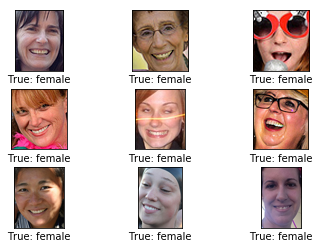

In [ ]:
# Load the first images from the train-set.
images = load_images(image_paths=image_paths_train[0:9])

# Get the true classes for those images.
cls_true = cls_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

### Class Weights

Sometimes the dataset is quite imbalanced because it has few images of one class when compared to the rest. This can cause a problem during training because the neural network will be shown many more examples of one class, so it might become better at recognizing that particular class.

Here we use scikit-learn to calculate weights that will properly balance the dataset. These weights are applied to the gradient for each image in the batch during training, so as to scale their influence on the overall gradient for the batch.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

Note how the weight is about 1.398 for the forky-class and only 0.707 for the spoony-class. This is because there are fewer images for the forky-class so the gradient should be amplified for those images, while the gradient should be lowered for spoony-images.

In [ ]:
class_weight

array([0.98968231, 1.01053508])

In [ ]:
class_names

['female', 'male']

## Example Predictions

Here we will show a few examples of using the pre-trained VGG16 model for prediction.

We need a helper-function for loading and resizing an image so it can be input to the VGG16 model, as well as doing the actual prediction and showing the result.

In [ ]:
def predict(image_path):
    # Load and resize the image using PIL.
    img = Image.open(image_path)
    img_resized = img.resize(input_shape, Image.LANCZOS)

    # Plot the image.
    plt.imshow(img_resized)
    plt.show()

    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)

    # Use the VGG16 model to make a prediction.
    # This outputs an array with 1000 numbers corresponding to
    # the classes of the ImageNet-dataset.
    pred = model.predict(img_array)
    
    # Decode the output of the VGG16 model.
    pred_decoded = decode_predictions(pred)[0]

    # Print the predictions.
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

We can then use the VGG16 model on a picture of a parrot which is classified as a macaw (a parrot species) with a fairly high score of 79%.

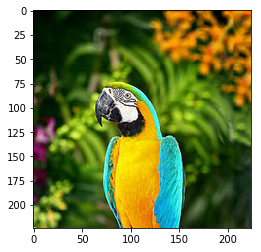

79.02% : macaw
 6.61% : bubble
 3.64% : vine_snake
 1.90% : pinwheel
 1.22% : knot


In [ ]:
predict(image_path='images/parrot_cropped1.jpg')

We can then use the VGG16 model to predict the class of one of the images in our new training-set. The VGG16 model is very confused about this image and cannot make a good classification.

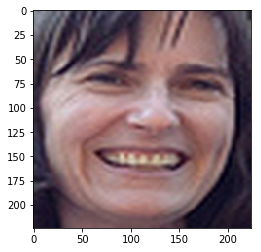

32.17% : sweatshirt
19.07% : neck_brace
 8.33% : sunscreen
 3.24% : face_powder
 3.11% : lab_coat


In [ ]:
predict(image_path=image_paths_train[0])

We can try it for another image in our new training-set and the VGG16 model is still confused.

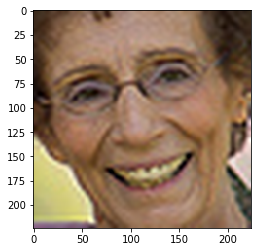

27.06% : sweatshirt
 7.56% : mask
 7.26% : sunscreen
 6.55% : ski_mask
 4.96% : lab_coat


In [ ]:
predict(image_path=image_paths_train[1])

We can also try an image from our new test-set, and again the VGG16 model is very confused.

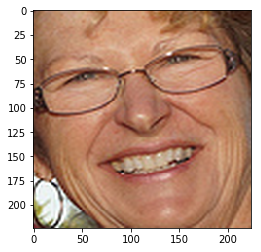

39.55% : mask
 5.62% : wig
 3.71% : sunscreen
 3.04% : bubble
 2.57% : goblet


In [ ]:
predict(image_path=image_paths_test[0])

## Transfer Learning

The pre-trained VGG16 model was unable to classify images from the Every Politician dataset. The reason is perhaps that the VGG16 model was trained on the so-called ImageNet dataset which may not have contained many images of faces.

The lower layers of a Convolutional Neural Network can recognize many different shapes or features in an image. It is the last few fully-connected layers that combine these featuers into classification of a whole image. So we can try and re-route the output of the last convolutional layer of the VGG16 model to a new fully-connected neural network that we create for doing classification on the Every Politican dataset.

First we print a summary of the VGG16 model so we can see the names and types of its layers, as well as the shapes of the tensors flowing between the layers.

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

We can see that the last convolutional layer is called 'block5_pool' so we use Keras to get a reference to that layer.

In [ ]:
transfer_layer = model.get_layer('block5_pool')

We refer to this layer as the Transfer Layer because its output will be re-routed to our new fully-connected neural network which will do the classification for the Knifey-Spoony dataset.

The output of the transfer layer has the following shape:

In [ ]:
transfer_layer.output

<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>

Using the Keras API it is very simple to create a new model. First we take the part of the VGG16 model from its input-layer to the output of the transfer-layer. We may call this the convolutional model, because it consists of all the convolutional layers from the VGG16 model.

In [ ]:
conv_model = Model(inputs=model.input, outputs=transfer_layer.output)

We can then use Keras to build a new model on top of this.

In [ ]:
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(dropout_rate))

# Let's add a 2nd layer to make the new classifier deeper
new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(dropout_rate))

# Let's add a 3rd layer to make the new classifier deeper
# new_model.add(Dense(1024, activation='relu'))
# new_model.add(Dropout(dropout_rate))

# Add the final layer for the actual classification.
new_model.add(Dense(num_classes, activation='softmax'))

We use the Adam optimizer with a fairly low learning-rate (1e-5). The learning-rate could perhaps be larger. But if you try and train more layers of the original VGG16 model, then the learning-rate should be quite low otherwise the pre-trained weights of the VGG16 model will be distorted and it will be unable to learn.

We will use a lower learning-rate (1e-7) when fine-tuning so the weights of the original VGG16 model only get changed slowly.

In [ ]:
optimizer = Adam(lr = learning_rate)
print('learning rate = ' + str(learning_rate))

learning rate = 1e-07


We have 2 classes in the Every Politician and DiF datasets so Keras needs to use this loss-function.

In [ ]:
loss = 'categorical_crossentropy'

The only performance metric we are interested in is the classification accuracy.

In [ ]:
metrics = ['categorical_accuracy']

# Train layers in VGG16
The layers to train in the VGG16 are defined at the top. This block replaces the need to run "Fine Tuning" at the end of the notebook.

Helper-function for printing whether a layer in the VGG16 model should be trained. By default all the layers of the VGG16 model are trainable.

In [ ]:
def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))
        
print_layer_trainable()

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In Transfer Learning generally only interested in reusing the pre-trained VGG16 model as it is, but we will enable training the VGG16 if we indicate blocks for training in `VGG16_blocks`.

## Training and Fine-Tuning

In Transfer Learning the original pre-trained model is locked or frozen during training of the new classifier. This ensures that the weights of the original VGG16 model will not change. One advantage of this, is that the training of the new classifier will not propagate large gradients back through the VGG16 model that may either distort its weights or cause overfitting to the new dataset.

But once the new classifier has been trained we can try and gently fine-tune some of the deeper layers in the VGG16 model as well. We call this Fine-Tuning.

It is a bit unclear whether Keras uses the `trainable` boolean in each layer of the original VGG16 model or if it is overrided by the `trainable` boolean in the "meta-layer" we call `conv_layer`. So we will enable the `trainable` boolean for both `conv_layer` and all the relevant layers in the original VGG16 model.

In [ ]:
conv_model.trainable = (len(VGG16_blocks) > 0)
print('VGG16 model trainable = ' + str(conv_model.trainable))

VGG16 model trainable = True


Here we set which layers are trainable.

In [ ]:
if 'all' not in VGG16_blocks: # leave everything set to True
    for layer in conv_model.layers:
        layer.trainable = (layer.name[0:6] in VGG16_blocks)
    
print_layer_trainable()

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


Once we have changed whether the model's layers are trainable, we need to compile the model for the changes to take effect.

In [ ]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

An epoch normally means one full processing of the training-set. But the data-generator that we created above, will produce batches of training-data for eternity. So we need to define the number of steps we want to run for each "epoch" and this number gets multiplied by the batch-size defined above. For example, 100 steps per epoch and a batch-size of 20 would mean each "epoch" consists of 2000 random images from the training-set.

The reason these particular numbers were chosen was because they seemed to be sufficient for training with this particular model and dataset and it didn't take too much time, resulting in 20 data-points (one for each "epoch") which can be plotted afterwards.

In [ ]:
epochs = 1 # 10 at 25 min per epoch this should take ~4.5 hours.
steps_per_epoch = 2000 # 2000 x 10 = 10k per epoch and should take ~26 min

### Reload saved 'new model'

If there exists any already trained 'new model,' reload it an continue training.

In [ ]:
if os.path.exists(new_model_filename): # check to see that saved new model exists
    print('Reloading ' + new_model_filename)
    new_model = load_model(new_model_filename)
else:
    print('Not loading a saved model.')

history = loadHist(history_filename) # will return {} if file not there

# This should be excluded because conv_model is part of new_model
# if os.path.exists(conv_model_filename): # load VGG16 model if it's there
#     print('Reloading ' + conv_model_filename)
#     conv_model = load_model(conv_model_filename)
#     # avoids WARNING:tensorflow:No training configuration found in save file:
#     # the model was *not* compiled. Compile it manually.
#     new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Reloading data/2x1024fc_b10_vall.h5


### Use Callbacks to save model and history after each epoch

This is to save work if training crashes for whatever reason.

In [ ]:
class LossHistory(Callback):
    
    # https://stackoverflow.com/a/53653154/852795
    def on_epoch_end(self, epoch, logs = None):
        new_history = {}
        for k, v in logs.items(): # compile new history from logs
            new_history[k] = [v] # convert values into lists
        current_history = loadHist(history_filename) # load history from current training
        current_history = appendHist(current_history, new_history) # append the logs
        saveHist(history_filename, current_history) # save history from current training
#         if len(VGG16_blocks) > 0: # save VGG16 model if we are training blocks
#             conv_model.save(conv_model_filename)

model_checkpoint = ModelCheckpoint(new_model_filename, verbose = 0, period = 1)
history_checkpoint = LossHistory()
callbacks_list = [model_checkpoint, history_checkpoint]

Training the new model is just a single function call in the Keras API.

In [ ]:
new_model_result = new_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test,
                                  callbacks=callbacks_list)

history = appendHist(history, new_model_result.history)

Epoch 1/1
2000/2000 [==============================] - 1584s 792ms/step - loss: 0.1427 - categorical_accuracy: 0.9506 - val_loss: 0.1282 - val_categorical_accuracy: 0.9509


Keras records the performance metrics at the end of each "epoch" so they can be plotted later. This shows that the loss-value for the training-set generally decreased during training, but the loss-values for the test-set were a bit more erratic. Similarly, the classification accuracy generally improved on the training-set while it was a bit more erratic on the test-set.

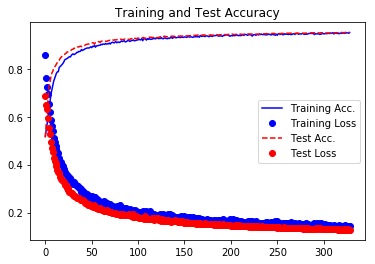

# epochs = 329


In [ ]:
# history = loadHist(history_filename) # use this to recover history after a crash
plot_training_history(history)
print('# epochs = ' + str(len(history['categorical_accuracy'])))

After training we can also evaluate the new model's performance on the test-set using a single function call in the Keras API.

In [ ]:
result = new_model.evaluate_generator(generator_test, steps=steps_test)

In [ ]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 95.09%


We can plot some examples of mis-classified images from the test-set. Some of these images are also difficult for a human to classify.

The confusion matrix shows that the new model is especially having problems classifying the forky-class.

In [ ]:
example_errors()

### Save 'new model' for continued training later
If the VGG16 has been fine-tuned, those weights are also saved in `new_model`. Save the training history, too, in order to pick that up where it left off.

In [ ]:
if new_model_filename != '': # if the filename is defined...
    new_model.save(new_model_filename) # ... save the model for reloading later
    saveHist(history_filename, history)

# Ledger of Classification Performance
## Politicians

56.8% - 1 FC layer with 1024 nodes and 50% dropout<br>
53.6% - 2 FC layers with 1024 nodes and 50% dropout, 20 epochs<br>
56.6% - 2 FC layers with 1024 nodes and 50% dropout, 40 epochs, batch_size 20<br>
57.0% - 2 FC layers with 1024 nodes and no dropout, 40 epochs, batch_size 8<br>
51.8% - 1 FC layer with 2048 nodes and no droupout

## Diversity in Faces - Gender Classification
~~~~
68.5% - 1x1024 FC, 50% dropout, batch 20,    20 epochs, 1000 images
75.8% - 1x1024 FC, 50% dropout, batch 20,    50 epochs,  10k images
73.6% - 2x512  FC, 50% dropout, batch 64,    50 epochs,  10k images
71.0% - 3x512  FC, 50% dropout, batch 32,    50 epochs,  10k images
64.0% - 1x1024 FC, 50% dropout, batch 20,   100 epochs,  10k images, VGG16 block 5
69.5% - 1x1024 FC, 50% dropout, batch 20,   250 epochs,  10k images, VGG16 block 5
89.1% - 1x1024 FC, 50% dropout, batch 10,    50 epochs, 855k images
88.8% - 1x2048 FC, 50% dropout, batch 10,  40k batches, 855k images
87.5% - 2x1024 FC, 50% dropout, batch 20,  20k batches, 855k images
86.8% - 3x1024 FC, 80% dropout, batch 20,  40k batches, 855k images
89.2% - 3x1024 FC, 20% dropout, batch 20,  40k batches, 855k images
94.9% - 2x1024 FC, 50% dropout, batch 20,  26k batches, 855k images, VGG16 blocks 4 & 5
95.2% - 2x1024 FC, 50% dropout, batch 20,  28k batches, 855k images, VGG16 blocks 3, 4 & 5
95.0% - 2x1024 FC, 50% dropout, batch 10, 600k batches, 855k images, VGG16 all, 1e-7
~~~~

## Conclusion

We have taken two approaches of Transfer Learning (fixed and file-tuning) of the pre-trained VGG16 model on our dataset. We see that the accuracy is not high enough with both the approaches. In this case fine-tuning doesn't improve the accuracy any more than prior approach. 

This model is not going to be a useful tool for political affiliation prediction. We need to look into predicting other traits from the images like emotion, race, gender, etc.

**Notes**

conda create --name tf_gpu tensorflow-gpu <-- create conda environment with TF GPU<br>
conda install jupyter <-- this will install pip<br>
pip install matplotlib<br>
pip install pillow <-- do not use pil<br>
pip install sklearn<br>
while (1) {./nvidia-smi; sleep 5} <-- monitor GPU in PowerShell at C:\Program Files\NVIDIA Corporation\NVSMI